<a href="https://colab.research.google.com/github/nishant16294-art/-Supervised-Machine-Learning-CatBoost-/blob/main/Supervised_Machine_Learning_(CatBoost).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Name:** Rented Bike Count Prediction


**Project Type:** Supervised Machine Learning (CatBoost)



**Project Statement**


The goal of this project is to predict the number of bikes rented in a given hour based on various features such as temperature, humidity, wind speed, time of day, and more.

Accurate prediction can help bike-sharing companies plan inventory, optimize operations, and meet demand effectively.**


**Let's Begin !**

In [ ]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


**# Data Set Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = ('/content/drive/MyDrive/almabetter_project/SeoulBikeData.csv')
df = pd.read_csv(file_path, encoding='latin1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Dataset First view
print(df.head())


print('\n\n\n')
# Dataset Rows & Columns count
print(df.shape)


print('\n\n')
# Dataset Info
print(df.info())

print('\n\n')
# # Dataset Duplicate Value Count
print("All duplicate value count:",df.duplicated().sum())


print('\n\n')
# Missing Values/Null Values Count
print(" missing value:")
print('\n')
print(df.isnull().sum())



         Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01-12-2017                254     0             -5.2           37   
1  01-12-2017                204     1             -5.5           38   
2  01-12-2017                173     2             -6.0           39   
3  01-12-2017                107     3             -6.2           40   
4  01-12-2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   


**Step 3**:  Feature Engineering

In [ ]:
# Step 1: Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Step 2: Create new features from 'Date'
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday  # Monday=0, Sunday=6
df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Step 3: Optional - Create time-of-day bins (peak/off-peak)
def hour_group(hour):
    if 6 <= hour < 10:
        return 'Morning_Peak'
    elif 17 <= hour < 21:
        return 'Evening_Peak'
    elif 10 <= hour < 17:
        return 'Day_Time'
    else:
        return 'Night'

df['Hour_Group'] = df['Hour'].apply(hour_group)

# Step 4: Create flags for rain/snow
df['Has_Rain'] = df['Rainfall(mm)'].apply(lambda x: 1 if x > 0 else 0)
df['Has_Snow'] = df['Snowfall (cm)'].apply(lambda x: 1 if x > 0 else 0)

# Preview the modified DataFrame
print(df.head())


        Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0 2017-12-01                254     0             -5.2           37   
1 2017-12-01                204     1             -5.5           38   
2 2017-12-01                173     2             -6.0           39   
3 2017-12-01                107     3             -6.2           40   
4 2017-12-01                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  ...  Seasons     Holiday  \
0                      0.0           0.0  ...   Winter  No Holiday   
1                      0

**Step 4:** Categorical Features Identification (for CatBoost)

In [ ]:
# List of categorical features (based on original + engineered columns)
cat_features = [
    'Seasons',
    'Holiday',
    'Functioning Day',
    'Hour_Group',
    'Month',
    'Weekday',
    'Is_Weekend',
    'Has_Rain',
    'Has_Snow'
]


**Step 5:** Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# 🎯 Step 1: Define target and features
target = 'Rented Bike Count'

# Drop columns that shouldn't be used as input features
drop_cols = ['Date', 'Rented Bike Count']  # 'Date' is now used via derived columns
X = df.drop(columns=drop_cols)
y = df[target]

# 🎯 Step 2: Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check shape
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (7008, 19)
Test shape: (1752, 19)


**Step 6:** CatBoost Pool Creation & Model Training

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor, Pool


In [ ]:
# ✅ Import
from catboost import CatBoostRegressor, Pool

# ✅ Define categorical features (column names)
cat_features = ['Seasons', 'Holiday', 'Functioning Day', 'Month', 'Day', 'Weekday', 'Is_Weekend', 'Hour_Group', 'Has_Rain', 'Has_Snow']


# ✅ Create Pool objects (optional but recommended for large datasets)
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

# ✅ Initialize the CatBoost Regressor
model_cb = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    cat_features=cat_features,   # Optional here if using Pool
    verbose=100,
    random_seed=42
)

model_cb.fit(train_pool, eval_set=test_pool)



0:	learn: 602.7718094	test: 604.6251301	best: 604.6251301 (0)	total: 61.5ms	remaining: 30.7s
100:	learn: 178.8155676	test: 190.2192063	best: 190.2192063 (100)	total: 2.24s	remaining: 8.84s
200:	learn: 152.1120957	test: 171.2368744	best: 171.2368744 (200)	total: 3.4s	remaining: 5.07s
300:	learn: 135.0812854	test: 162.6862867	best: 162.6862867 (300)	total: 4.55s	remaining: 3.01s
400:	learn: 124.3255666	test: 158.4026666	best: 158.4026666 (400)	total: 5.72s	remaining: 1.41s
499:	learn: 115.7251230	test: 154.8484663	best: 154.8374195 (495)	total: 8.17s	remaining: 0us

bestTest = 154.8374195
bestIteration = 495

Shrink model to first 496 iterations.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 🔍 Predict on test set
y_pred = model_cb.predict(X_test)

# 📏 Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 📢 Print results
print(f"✅ R² Score: {r2:.4f}")
print(f"📉 MAE: {mae:.2f}")
print(f"📉 MSE: {mse:.2f}")
print(f"📉 RMSE: {rmse:.2f}")


✅ R² Score: 0.9425
📉 MAE: 92.92
📉 MSE: 23974.63
📉 RMSE: 154.84


The R² score was around 94%, which means the model is very accurate — it explains 94% of the changes in the bike rental numbers. That’s a strong performance.

The MAE (Mean Absolute Error) was about 93 bikes, which means the model is usually off by around 93 bikes when it makes a prediction.

The RMSE (Root Mean Squared Error) was about 155 bikes, which is another way of saying that the prediction is sometimes off by that much, but it gives more weight to bigger errors.

**Step 8:** Feature Importance (CatBoost Model)

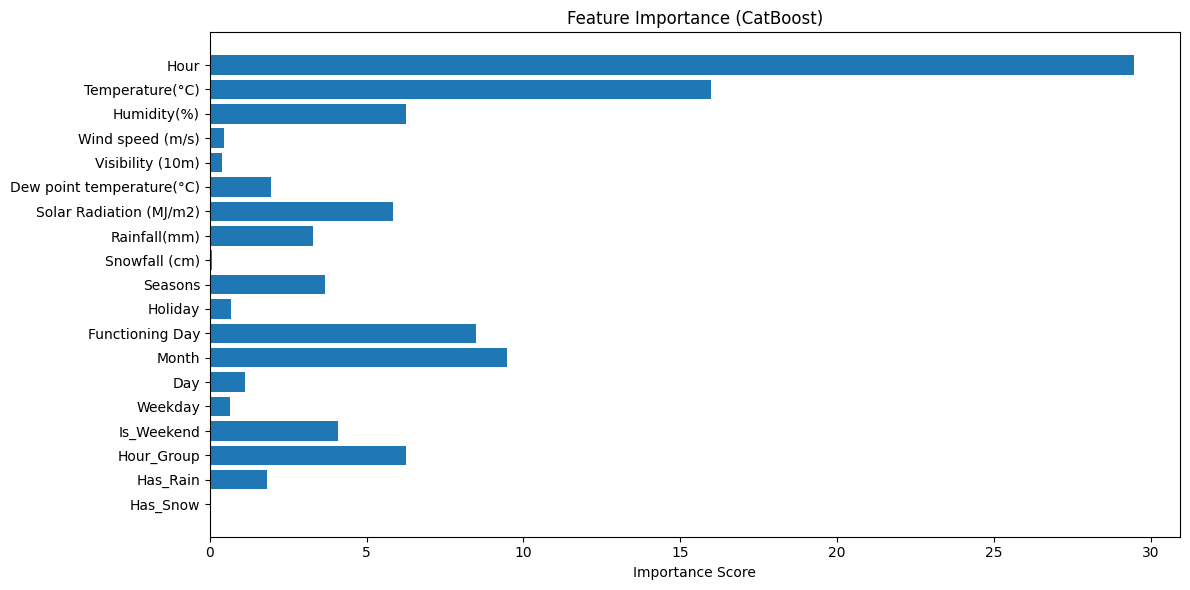

In [ ]:
import matplotlib.pyplot as plt

# 🎯 Feature Importance nikalna
feature_importance = model_cb.get_feature_importance()
feature_names = X_train.columns

# 📊 Plot karna
plt.figure(figsize=(12, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel("Importance Score")
plt.title("Feature Importance (CatBoost)")
plt.gca().invert_yaxis()  # Important features upar dikhe
plt.tight_layout()
plt.show()


**Step 10:** Business Conclusion

Key Insights:

Hour of the day is the most important factor
→ Most people rent bikes during morning office hours and evening time. So, more bikes should be available during these times.

Temperature affects rentals
→ On pleasant days, people prefer renting bikes. In extreme weather (too hot, rainy, or snowy), demand drops.

Weekends and Holidays matter
→ Fewer rentals happen on holidays or weekends, probably because there’s no office or regular routine.

Weather conditions like humidity, rainfall, and snow also play a small role.



**How this helps the business:**

Companies can predict demand and optimize bike availability.

Authorities can manage traffic better by promoting bike rentals in peak hours.

Helps in planning infrastructure – like building more bike stands in busy areas.

